In [1]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import CSVLogger

//anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
#変数設定
n_categories=2
batch_size=32
train_dir='train'
validation_dir='validation'
file_name='vgg16_fine'


In [3]:
#　base_modelモデル作成
base_model=VGG16(weights='imagenet',include_top=False,
                 input_tensor=Input(shape=(224,224,3)))

In [4]:
#　パラメータ設定, model作成
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
prediction=Dense(n_categories,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)

In [5]:
#　modelのcompile実施
# メモリ最適化のためoptimizerはSGDを設定
for layer in base_model.layers[:15]:
    layer.trainable=False

model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
#学習用データ作成(cat:80枚、dog:80枚)
#評価用データ作成(cat:40枚、dog:40枚)
train_datagen=ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen=ImageDataGenerator(rescale=1.0/255)

In [7]:
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 160 images belonging to 2 classes.


In [8]:
validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 80 images belonging to 2 classes.


In [9]:
#学習用と評価用データをVGG16モデルに適用
hist=model.fit_generator(train_generator,
                         steps_per_epoch=5,
                         validation_steps=2.5,
                         epochs=200,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=[CSVLogger(file_name+'.csv')])
#save weights
model.save(file_name+'.h5')

Epoch 1/200
5/5 [==============================] - 186s 37s/step - loss: 0.7946 - acc: 0.5000 - val_loss: 0.7718 - val_acc: 0.5000
Epoch 2/200
5/5 [==============================] - 170s 34s/step - loss: 0.7404 - acc: 0.5000 - val_loss: 0.7160 - val_acc: 0.5000
Epoch 3/200
5/5 [==============================] - 143s 29s/step - loss: 0.7010 - acc: 0.4937 - val_loss: 0.6823 - val_acc: 0.5250
Epoch 4/200
5/5 [==============================] - 155s 31s/step - loss: 0.6838 - acc: 0.5812 - val_loss: 0.6761 - val_acc: 0.5875
Epoch 5/200
5/5 [==============================] - 150s 30s/step - loss: 0.6840 - acc: 0.5625 - val_loss: 0.6769 - val_acc: 0.5625
Epoch 6/200
5/5 [==============================] - 145s 29s/step - loss: 0.6822 - acc: 0.5312 - val_loss: 0.6747 - val_acc: 0.5625
Epoch 7/200
5/5 [==============================] - 148s 30s/step - loss: 0.6764 - acc: 0.5375 - val_loss: 0.6695 - val_acc: 0.6125
Epoch 8/200
5/5 [==============================] - 145s 29s/step - loss: 0.6684 - a

In [ ]:
学習モデルの結果
loss: 0.0553
acc: 0.9938 

# 学習履歴のグラフ化

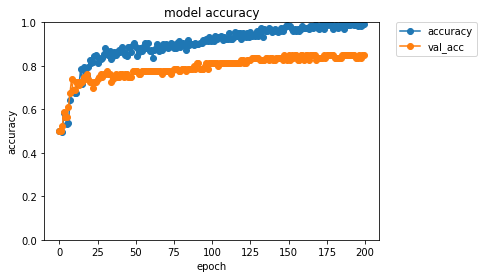

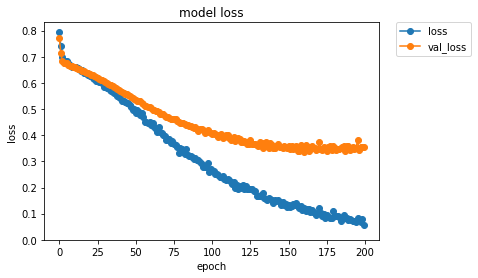

In [12]:
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
def plot_history(history):
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim(ymin=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
plot_history(hist)

# テストデータ適用(cat:80枚 dog:80枚)

In [13]:
from keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import os,random
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

In [26]:
batch_size=32
test_dir='test'

In [27]:
test_datagen=ImageDataGenerator(rescale=1.0/255)

test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 160 images belonging to 2 classes.


In [28]:
score=model.evaluate_generator(test_generator)
print('\n test loss:',score[0])
print('\n test_acc:',score[1])


 test loss: 0.44679873883724214

 test_acc: 0.81875


# サンプルデータと予測結果

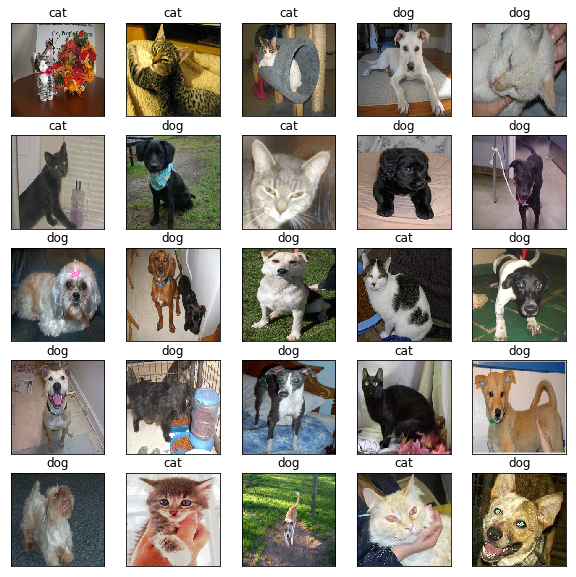

In [33]:
#今回は、1列4行目４列１行目の二箇所以外は正解と思われる結果となる。

display_dir='display'
%matplotlib inline
files=os.listdir(display_dir)
img=random.sample(files,25)

plt.figure(figsize=(10,10))
for i in range(25):
    temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(224,224))
    plt.subplot(5,5,i+1)
    plt.imshow(temp_img)
    #正規化
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #予測結果表示
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    plt.xticks([]),plt.yticks([])
plt.show()

# 備考

In [32]:
#モデルのパラメータをjsonに保存
json_string=model.to_json()
open(file_name+'.json','w').write(json_string)

11593